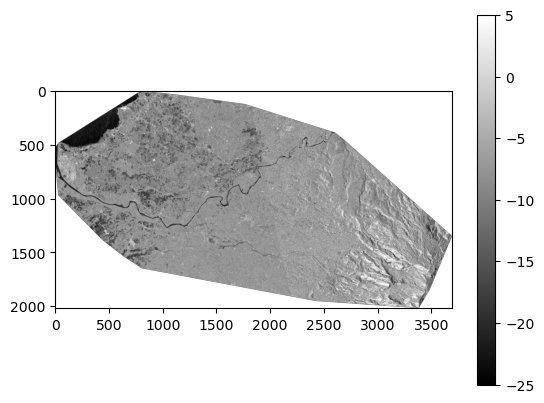

In [1]:
import numpy as np
import rasterio
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

s1_path = fr"D:\Users\FRAN\Documents\IPA\GUI_project\ipa_floodmap_samples\bago_s1_20251104_peak.tif"

with rasterio.open(s1_path) as src:
    vv_db = src.read(1).astype(np.float32)
    profile = src.profile

def db_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_db(band):
    return 10*np.log10(band)

def lee_filter(band, window, var_noise = 0.25):
        # band: SAR data to be despeckled (already reshaped into image dimensions)
        # window: descpeckling filter window (tuple)
        # default noise variance = 0.25
        # assumes noise mean = 0
    
        mean_window = uniform_filter(band, window)
        mean_sqr_window = uniform_filter(band**2, window)
        var_window = mean_sqr_window - mean_window**2

        weights = var_window / (var_window + var_noise)
        band_filtered = mean_window + weights*(band - mean_window)
        return band_filtered

vv_lin = db_to_linear(vv_db)
vv_lin_filt = lee_filter(vv_lin, window=5)
vv_db_filt = linear_to_db(vv_lin_filt)



plt.imshow(vv_db, cmap="gray", vmin=-25, vmax=5)
plt.colorbar()
plt.show()


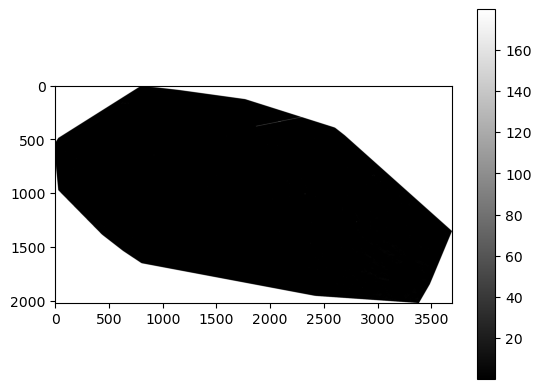

In [8]:
plt.imshow(vv_lin, cmap="gray")
plt.colorbar()
plt.show()

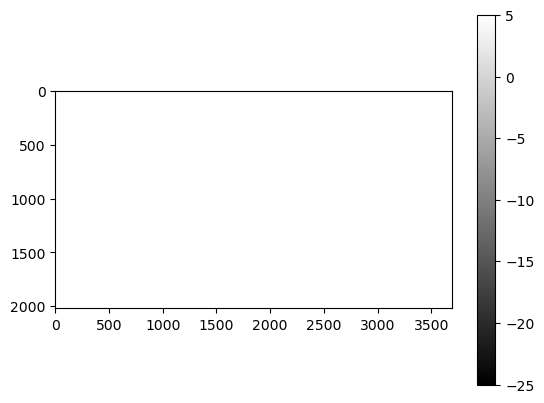

In [7]:
plt.imshow(vv_db_filt, cmap="gray", vmin=-25, vmax=5)
plt.colorbar()
plt.show()

In [15]:
print(np.min(vv_db), np.min(vv_db))
# print(vv_lin.min(), vv_lin.max())


nan nan


In [12]:
type(vv_db)

numpy.ndarray

In [6]:
import rasterio
import numpy as np
from scipy.ndimage import uniform_filter
from matplotlib.patches import Patch

s1_path = fr"D:\Users\FRAN\Documents\IPA\GUI_project\ipa_floodmap_samples\bago_s1_20251104_peak.tif"

def db_to_linear_safe(db_array):
    """Convert dB to linear scale, skipping NaNs."""
    lin = np.full_like(db_array, np.nan, dtype=np.float32)
    mask = ~np.isnan(db_array)
    lin[mask] = 10 ** (db_array[mask] / 10)
    return lin

def linear_to_db_safe(lin_array):
    """Convert linear to dB safely, avoiding log(0)."""
    db = np.full_like(lin_array, np.nan, dtype=np.float32)
    mask = ~np.isnan(lin_array)
    db[mask] = 10 * np.log10(np.maximum(lin_array[mask], 1e-8))
    return db

def lee_filter_nan(img, size=5):
    """
    Lee speckle filter with NaN handling.
    img: linear scale SAR image
    size: kernel size (e.g., 5)
    """
    # Replace NaNs with 0 temporarily for convolution
    img_filled = np.nan_to_num(img, nan=0.0)
    
    # Local mean and variance
    mean = uniform_filter(img_filled, size)
    mean_sq = uniform_filter(img_filled**2, size)
    var = mean_sq - mean**2
    
    # Noise variance
    noise_var = np.nanmean(var)
    
    # Lee weighting
    w = var / (var + noise_var)
    result = mean + w * (img_filled - mean)
    
    # Restore NaNs for NoData
    result[np.isnan(img)] = np.nan
    return result


with rasterio.open(s1_path) as src:
    # Read with masking (handles NoData)
    vv = src.read(1, masked=True)
    profile = src.profile
    vv_data = vv.filled(np.nan)  # convert masked array to NaN

# Convert to linear scale safely
vv_lin = db_to_linear_safe(vv_data)

# Apply Lee filter
vv_lin_filt = lee_filter_nan(vv_lin, size=5)

# Convert back to dB safely
vv_db_filt = linear_to_db_safe(vv_lin_filt)



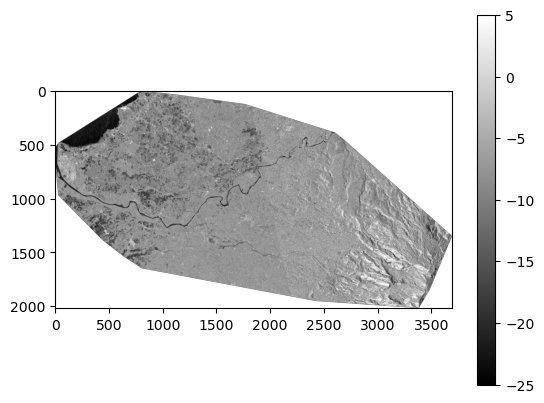

In [3]:
plt.imshow(vv_db, cmap="gray", vmin=-25, vmax=5)
plt.colorbar()
plt.show()


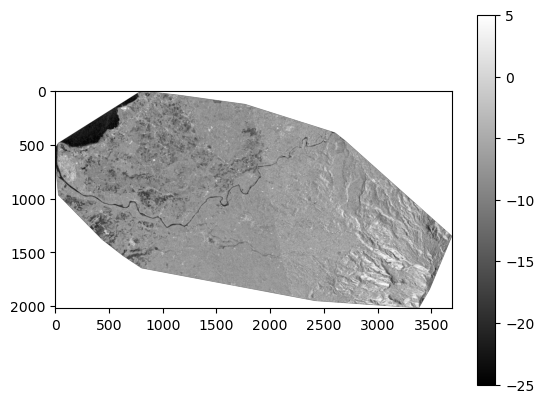

In [4]:
plt.imshow(vv_db_filt, cmap="gray", vmin=-25, vmax=5)
plt.colorbar()
plt.show()

In [21]:
print(np.min(vv_db), np.max(vv_db))
print(np.min(vv_db_filt), np.max(vv_db_filt))


nan nan
nan nan


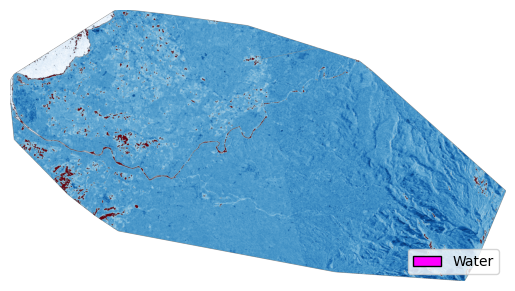

In [13]:
s1_peak = vv_db_filt
vv_thresh = (-20, -15)
mask_peak = ( (s1_peak > vv_thresh[0]) & (s1_peak < vv_thresh[1]) ).astype(np.uint8)
mask_peak = np.where(mask_peak == 1, 1, np.nan)

# fig1, ax1 = plt.subplots()
# ax1.imshow(vv_db_filt, cmap="gray", vmin=-25, vmax=5)
# ax1.imshow(mask_peak, cmap="Reds", alpha=1.0)
# fig1.colorbar()
# fig1.show()

fig1, ax1 = plt.subplots()
ax1.imshow(vv_db_filt, cmap="Blues", vmin=-25, vmax=5)
ax1.imshow(mask_peak, cmap="Reds", vmin=0, vmax=1, alpha=1.0)
legend_elements = [Patch(facecolor="fuchsia", edgecolor="black", label="Water")]
ax1.legend(handles=legend_elements, loc="lower right", frameon=True)
ax1.axis("off")
plt.show()


In [ ]:
# --- Colormap & normalization ---
colors = ["white", "red", "yellow", "fuchsia"]  # 0/NaN, 1, 10, 11
bounds = [0, 1, 10, 11, 12]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
ax3.imshow(s2_rgb)

ax3.imshow(
    mask_rgb,
    cmap=cmap,
    norm=norm,
    alpha=mask_opacity
)

ax3.set_title(f"Flood Dynamics from {s1_peak_date} to {s1_post_date}")

# --- Legend (proxy artists) ---
legend_elements = [
    Patch(facecolor="red", edgecolor="black", label="Peak flood only"),
    Patch(facecolor="yellow", edgecolor="black", label="Post-flood only"),
    Patch(facecolor="fuchsia", edgecolor="black", label="Persistent water"),
]

ax3.legend(
    handles=legend_elements,
    loc="lower right",
    frameon=True,
    title="Flood Class"
)